In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [31]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [32]:
from pathlib import Path
data_dir = Path('/gdrive/My Drive/Colab Notebooks/final_project_first_images/')

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [33]:
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir / 'train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir / 'test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [34]:
model = models.resnet101(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1)) # try changing this to sigmoid

criterion = nn.NLLLoss() # look at options

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

In [36]:
epochs = 10
steps = 0
running_loss = 0
print_every = 1
train_loss_list = []
test_loss_list = []
accuracy_list = []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss_list.append(loss.item())

        print(steps)

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    test_loss_list.append(batch_loss.item())
                    train_loss_list.append(loss.item())
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    acc =  torch.mean(equals.type(torch.FloatTensor)).item()
                    accuracy += acc
                    accuracy_list.append(acc)

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

1
Epoch 1/10.. Train loss: 0.713.. Test loss: 4.176.. Test accuracy: 0.476
2
Epoch 1/10.. Train loss: 3.706.. Test loss: 1.096.. Test accuracy: 0.524
3
Epoch 1/10.. Train loss: 0.662.. Test loss: 2.071.. Test accuracy: 0.524
4
Epoch 2/10.. Train loss: 2.181.. Test loss: 1.172.. Test accuracy: 0.524
5
Epoch 2/10.. Train loss: 1.337.. Test loss: 0.647.. Test accuracy: 0.476
6
Epoch 2/10.. Train loss: 0.750.. Test loss: 0.897.. Test accuracy: 0.476
7
Epoch 3/10.. Train loss: 0.973.. Test loss: 0.661.. Test accuracy: 0.476
8
Epoch 3/10.. Train loss: 0.653.. Test loss: 0.506.. Test accuracy: 0.929
9
Epoch 3/10.. Train loss: 0.566.. Test loss: 0.572.. Test accuracy: 0.548
10
Epoch 4/10.. Train loss: 0.654.. Test loss: 0.649.. Test accuracy: 0.524
11
Epoch 4/10.. Train loss: 0.848.. Test loss: 0.537.. Test accuracy: 0.571
12
Epoch 4/10.. Train loss: 0.783.. Test loss: 0.457.. Test accuracy: 0.893
13
Epoch 5/10.. Train loss: 0.622.. Test loss: 0.608.. Test accuracy: 0.500
14
Epoch 5/10.. Train

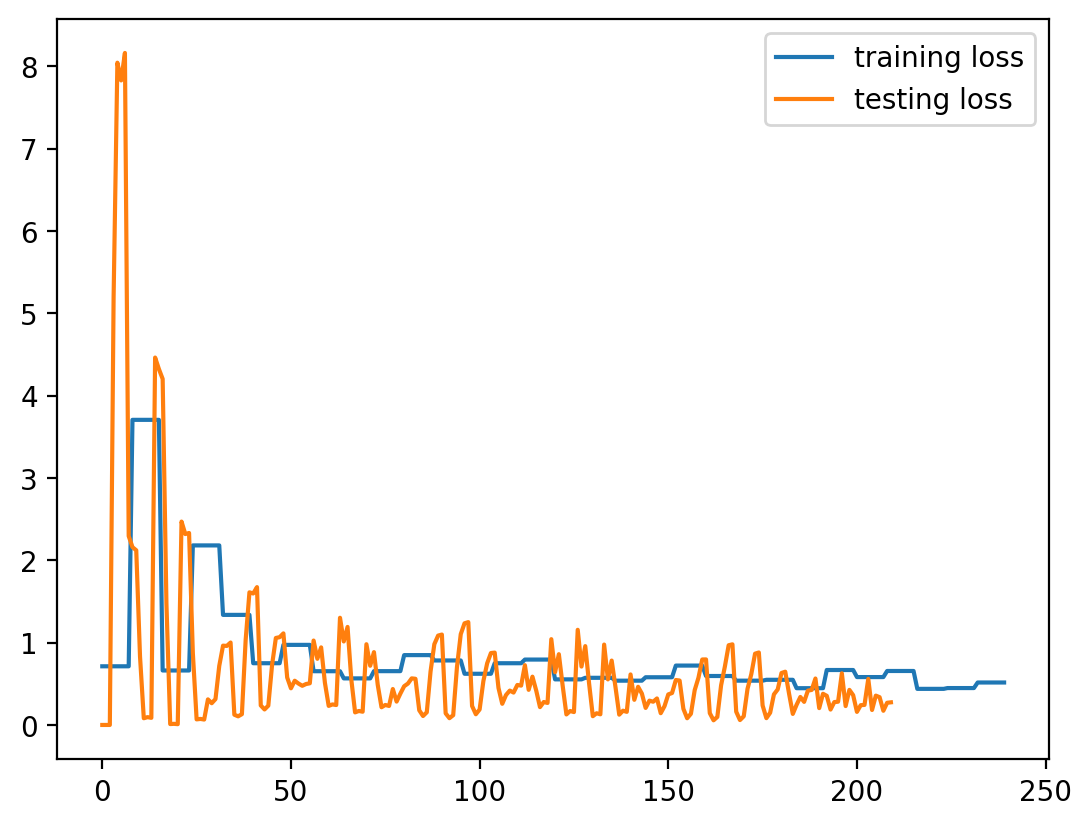

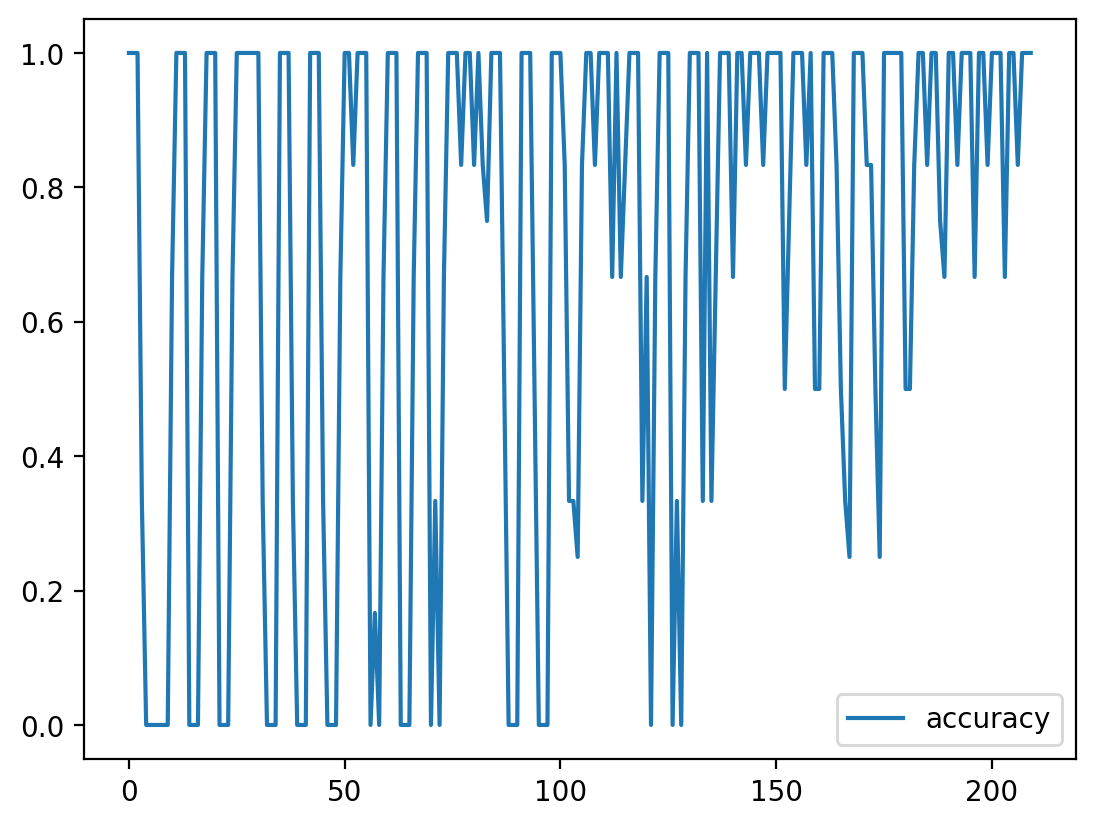

In [37]:
# plot performance
def plot_training(train_loss_list, test_loss_list, accuracy_list):
  plt.plot(train_loss_list,label='training loss')
  plt.plot(test_loss_list,label='testing loss')
  plt.legend()
  plt.show()
  plt.close()

  plt.plot(accuracy_list,label='accuracy')
  plt.legend()

plot_training(train_loss_list, test_loss_list, accuracy_list)

In [38]:
len(train_loss_list)

240

In [39]:
len(test_loss_list)

210